# Plot global DTA tree 


This notebook contains code for producing the full global tree, generated by running genomes from countries with >5 genomes though Beast 1.8 with a skyline population size prior, and inferring migration history with asymmetric DTA with BSSVA for all 15 countries. This script was adapted from [Louise Moncla's Mumps phylo work](https://github.com/blab/mumps-wa-phylodynamics)and from [Gytis Dudas'ebola work](https://github.com/ebov/space-time)

In [748]:
import baltic as bt
import pandas as pd
import arviz as az

from datetime import datetime as dt
from datetime import timedelta
import time
from io import StringIO
import altair as alt
from zipfile import ZipFile


import sys, subprocess, glob, os, shutil, re, importlib
from subprocess import call
import imp
from scipy.stats import gaussian_kde


%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
from matplotlib import rc
import textwrap as textwrap
from textwrap import wrap

import numpy as np
from scipy.special import binom

In [749]:
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 22})

In [750]:
def convertDate(x,start,end):
    """ Converts calendar dates between given formats """
    return dt.strftime(dt.strptime(x,start),end)

In [751]:
# set path to tree to load 
tree_path = "/Users/mparedes/Desktop/mpox_rhino/300_dta_country_mcc.tree"

In [752]:
# load trees
tree = bt.loadNexus(tree_path, tip_regex='_([0-9\-]+)$')
tree.setAbsoluteTime(2023.0068)

In [753]:
tree.treeStats()


Tree height: 0.837596
Tree length: 69.694904
strictly bifurcating tree
annotations present

Numbers of objects in tree: 597 (298 nodes and 299 leaves)



In [754]:
all_geos = []

for k in tree.Objects: 
    if k.branchType=='node':
        #print(k.traits)
        division = k.traits['country']
        all_geos.append(division)
print(set(all_geos))

{'Belgium', 'Slovenia', 'Switzerland', 'Italy', 'Colombia', 'UnitedKingdom', 'Austria', 'Peru', 'USA', 'Portugal', 'France', 'Germany', 'Spain', 'Slovakia', 'Canada'}


In [788]:
# add together probabilities for divisions in the same regions

# parse leaf and node information into a dictionary for plotting
metadata = {}
node_types = {}
node_probs = {}

for k in tree.Objects: ## iterate over objects in tree
    if k.branchType=='leaf':
        division = k.traits['country']
        #region = regions[division]
        metadata[k] = {}
        metadata[k]["division"] = division
        #metadata[k]["region"] = region
        node_probs[k] = k.traits["country.prob"]  # for a leaf, this is always 1.0
    
    # parse the nodes now and pick out the type trait
    if k.branchType=='node':
        node_division = k.traits["country"]
        division_prob = k.traits["country.prob"]
        
        #node_region = regions[node_division]       
        geo_set = k.traits['country.set']
        geo_set_prob = k.traits['country.set.prob']
        
        node_prob = 0
        for i in range(len(geo_set)):
            division = geo_set[i]
            #region = regions[division]
            geo_prob = geo_set_prob[i]
            
            #if region == node_region:
            node_prob += geo_prob
        
        
        node_types[k] = {}
        node_types[k]["division"] = node_division
        #node_types[k]["region"] = node_region 
        node_probs[k] = division_prob
        #division_probs[k] = division_prob
        #print(node_probs[k])

In [756]:


#region = {('Canada','USA'):'North America',
#          'Finland':'Northern Europe',
#          ('Austria','Germany','Switzerland','UnitedKingdom','France','Belgium','Netherlands'):'Western Europe', 
#          ('Slovakia','Slovenia'):'Central/Eastern Europe',
#          ('Italy','Portugal','Spain'):'Southern Europe',
#          ('Colombia','Peru'):'South America'}




         # blues
colors = {"Canada":"#133253",
          "USA":"#2664A5",
        
          
          # greens
          "UnitedKingdom":"#1C3828",
          "Germany":"#356D4C",
          "Switzerland":"#81A48F",
          "Austria":"#B3C8BC",
          "France":"#CCDAD2",

          "Belgium":"#438B62",
          #"Netherlands":"#60B684",

          
          # yellows
          "Slovakia":"#D0A854",
          "Slovenia":"#EEC060",

          
          # oranges
          "Italy":"#D07954",
          "Portugal":"#EEA160",
          "Spain":"#F4C49C",
          
          # purples
          "Colombia":"#2D1E45",
          "Peru":"#695B82",
          "ancestor":'grey'

          
          # reds

          #"Finland":"#C5656E"
         }

uncertainty_color = "#B9B9B9"

In [757]:
division_order = ["Canada",
"USA",
"UnitedKingdom",
"Germany",
"Switzerland",
"Austria",
"France",
"Belgium",
#"Netherlands",
"Slovakia",
"Slovenia",
"Italy",
"Portugal",
"Spain",
"Colombia",
"Peru"
#"Finland"
                
] 

In [811]:
# parse leaf and node information into a dictionary for plotting
metadata = {}
node_types = {}
node_probs = {}
pos_support = []

for k in tree.Objects: ## iterate over objects in tree
    if k.branchType=='leaf':
        division = k.traits['country']
        metadata[k] = {}
        metadata[k]["division"] = division
        node_probs[k] = k.traits["country.prob"]
    
    # parse the nodes now and pick out the type trait
    if k.branchType=='node':
        node_division = k.traits["country"]
        node_types[k] = {}
        node_types[k]["division"] = node_division
        node_probs[k] = k.traits["country.prob"]
        pos_support.append(k.traits["posterior"])

<generator object <genexpr> at 0x7ff1342f2ba0>
<generator object <genexpr> at 0x7ff1342f2ba0>
[2022.072535   2022.23553195]


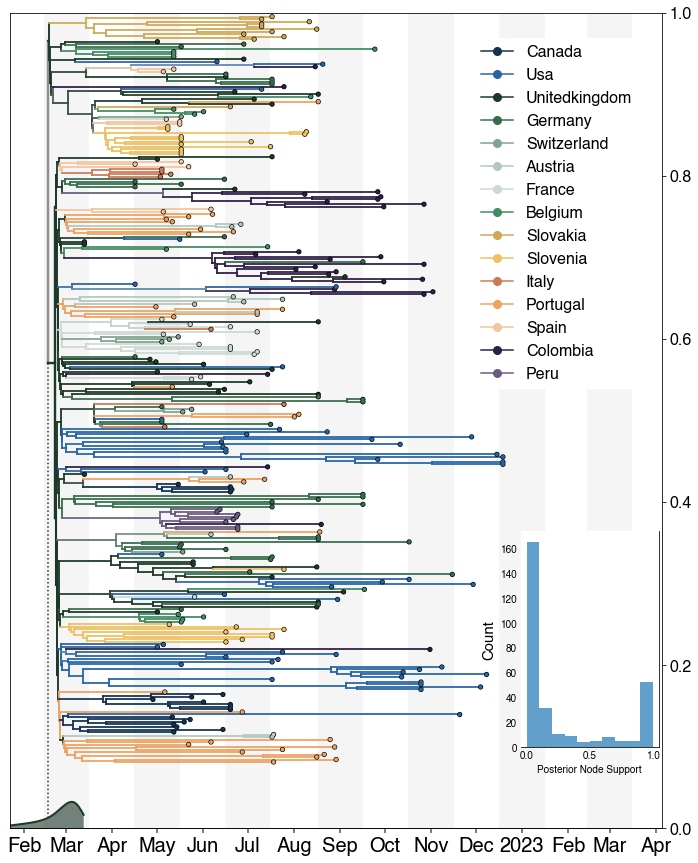

In [846]:
root_path = "/Users/mparedes/Desktop/mpox_rhino/300_dta_country_masked.log"
burnin=10000000
with open(root_path) as f:
    f = f.readlines()
for line in f:
    if not line.startswith("#"):
       
        l=line.strip('\n').split('\t')
        if l[0]=='state':
            header=l
            param_idx={x:i for i,x in enumerate(header)}
            params=header[1:]
            rootHeights={x:[] for x in params}
        elif float(l[0])>=burnin:
            for param in params:
                rootHeights[param].append(float(l[param_idx[param]]))

print (np.mean(x) for x in rootHeights.values())
print (np.median(x) for x in rootHeights.values())

print(az.hdi(np.array(rootHeights['age(root)']), 0.95))

fig,ax = plt.subplots(figsize=(12,15),facecolor='w')
ax2 = ax.twinx()


branchWidth=1.75 ## default branch width
tipSize = 15

#effects=[path_effects.Stroke(linewidth=2, foreground='w'),path_effects.Stroke(linewidth=0.5, foreground='k')]
offsetTree=25
# k objects are tips, nodes, branches
for k in tree.Objects: ## iterate over objects in tree
    x=k.absoluteTime ## or use absolute time instead
    y=k.y + offsetTree
    
    xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        base_color=colors[metadata[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color,base_color], N=256)
        c = color_ramp(node_probs[k])
        s=tipSize
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        number_children = len(k.leaves)
        node_branchwidth = branchWidth + number_children*0.0025
        base_color=colors[node_types[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color, base_color], N=256)
        c = color_ramp(node_probs[k])
        ax.plot([x,x],[k.children[-1].y+offsetTree,k.children[0].y+offsetTree],lw=node_branchwidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]
        
    ax.plot([xp,x],[y,y],lw=node_branchwidth,color=c,ls='-',zorder=9)
 #   ax.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=98)


for intro in rootHeights.keys():
    if intro=='age(root)':

        hpdLo,hpdHi=az.hdi(np.array(rootHeights['age(root)']), 0.95)

        x_grid=np.linspace(hpdLo,hpdHi,100)
        kde=gaussian_kde(rootHeights['age(root)'])
        y_grid=kde.evaluate(x_grid)

        root_y=[(y*0.8)-1 for y in y_grid]


        c='#1C3828'
            #intro='reservoir'



        topX,topY=tree.Objects[0].absoluteTime,tree.Objects[0].children[0].y+offsetTree

        bottomX=topX
        bottomY=(kde.evaluate(bottomX)*0.8)-1

        ax.plot([bottomX,topX],[bottomY,topY],ls=':',color=c)

        ax.fill_between(x_grid,root_y,y2=-1,facecolor= "#1C3828",edgecolor='none',alpha=0.6)
        ax.plot(x_grid,root_y,lw=2,color=c,ls='-')
    
    # add in a legend
    han_list = []

    # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
for key in division_order:
    marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
    han_list.append(marker)

    
ax3 = fig.add_axes([0.716, 0.2, 0.16, 0.2])
ax3.hist(pos_support, alpha = 0.7)
#ax.hist(pos_support, 50, density=True, facecolor='g', alpha=0.75)    
ax3.spines['left'].set_visible(False)
#ax.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False) 
ax3.set_xlabel("Posterior Node Support", size=10)
ax3.set_ylabel("Count", size=15)
ax3.tick_params(axis='x',labelsize=10,size=0)    

ax3.tick_params(axis='y',labelsize=10,size=0)    


    
xDates=['%04d-%02d-01'%(y,m) for y in range(2022,2024) for m in range(1,13)]

every=1
[ax.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=16,size=0)    
    
# set axis limits, remove border lines         
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.set_ylim(-1,(len(tree.Objects)+1)/2.0+offsetTree+1)
ax.set_xlim(2022.1,2023.3)
ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='x',labelsize=20,size=5, width=2,color='grey')
   # set date labels every 4
ax.set_yticklabels([])

# in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
# bbox arguments are: x, y, with 0 being furthest left and bottom
ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[0.70, 0.53], loc=3,prop={'size': 16}, facecolor='w')

#fig.tight_layout()
plt.gcf().subplots_adjust(right=0.88)
plt.savefig('../figures/mcc_dta_country_300.png',dpi=300,bbox_inches='tight')

plt.show()

key_order = {"Canada":1,
"USA":2,
"UnitedKingdom":3,
"Germany":4,
"Switzerland":5,
"Austria":6,
"France":7,
"Belgium":8,
#"Netherlands",
"Slovakia":9,
"Slovenia":10,
"Italy":11,
"Portugal":12,
"Spain":13,
"Colombia":14,
"Peru":15
#"Finland"
                
                 }

In [771]:
def enumerate_subtrees(tree):
    
    traitName="country"

    tree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    tree_strings={division:[] for division in division_order}
    subtype_trees={division:[] for division in division_order}

    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k

        ## get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName]      # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:       # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName]              # kploc = trait of parental node
        else:
            kploc='ancestor'

        kc=kloc     
        ## if states do not match
        if kloc!=kploc:      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName]==kloc     # traverse tree for all nodes whose traitname = kc
            #print('subtree resulting from %s>%s switch, traversing within %s'%(kploc,kloc,kloc))
            subtree=tree.subtree(k,traverse_condition=traverse_condition) #traitName = traitName ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()
                tree_strings[kloc].append(subtree.toString()) ## remember subtree string, subtree object itself
                subtype_trees[kloc].append((kploc,subtree))
    
    return(subtype_trees)

In [809]:
def plot_exploded_tree_no_cases(subtype_trees2, filename, width, height):
    
    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')

    traitName='country'
    tipSize=20
    mpl.rcParams['font.size']=16
    cumulative_y=0
    cutoff = 2022.1
    origin_size=150


    


    for i in reversed(sorted(subtype_trees2.keys(), key=lambda x:key_order[x])):
        starting_y = cumulative_y
        cumulative_y+=10
        for subtree in subtype_trees[i]:
            #print(tr) ## iterate over trait values
            origin = subtree[0]
            loc_tree = subtree[1]
            min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
            



            # count number of total leaves
            number_tips = 0
            for k in loc_tree.Objects:
                if k.branchType == "leaf":
                    number_tips += 1

            """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
            for each node. Do this for all except the horizontal line connecting the origin and the subtee"""
            for k in loc_tree.Objects:

                xp= k.parent.absoluteTime
                x = k.absoluteTime
                y = k.y + cumulative_y
                c = colors[k.traits[traitName]]
                s = tipSize
                a = k.traits["country.prob"]

                if k.branchType == "leaf":
                    ax1.scatter(x,y,s=tipSize,facecolor=c, alpha=a,edgecolor="black",zorder=100) ## plot tip circle
                    ax1.scatter(x,y,s=tipSize,facecolor="black", alpha=a,edgecolor="black",zorder=99)

                elif k.branchType == "node": 
                    # this plots the vertical lines connecting children and parents on tree
                    ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,alpha=a,ls='-',zorder=9)            
                    if k.traits['posterior']>=0.5:
                        ax1.scatter(x,y,s=70,facecolor='w',edgecolor=c,zorder=100)
               # if xp != loc_tree.root.absoluteTime:  # don't plot line connecting subtree to origin
        
                ax1.plot([xp, x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)   # this connects horizontal tree lines
#                     else:
#                         ax1.plot([x,cutoff],[y,y],"-",lw=branchWidth,color=c,zorder=9)   # this connects horizontal tree lines
                
                        
                        
                        
            """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
            that line be dotted or solid depending on how far back the origin is and how far back the node is"""
            # first, plot the origin circle
       # first, plot the origin circle
            oriC = colors[origin]

            oriX=loc_tree.root.parent.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
            if loc_tree.root.parent.traits['posterior']>=0.5:
                ax1.scatter(oriX,oriY,s=origin_size,facecolor=oriC,edgecolor='w',lw=2,zorder=200) ## add big circle at base of tree to indicate origin
            else:
                ax1.scatter(oriX,oriY,s=origin_size*0.5,facecolor=oriC,edgecolor='k',lw=1,zorder=200) ## add big circle at base of tree to indicate origin


#             #plot dotted line connecting circle to tree 
#             if min_node_x < cutoff: # whole thing before cutoff, whole thing dotted
#                 ax1.plot([oriX, min_node_x],[oriY,oriY], ":", color=c,lw=branchWidth,zorder=98)

#             elif oriX < cutoff: # partly before 2016, partial dotteds
#                 ax1.plot([cutoff, min_node_x],[oriY,oriY],"-",color=c,lw=branchWidth,zorder=98)
#                 ax1.plot([cutoff,oriX],[oriY,oriY],":",color=c,lw=branchWidth,zorder=98)

#             else:
 #           ax1.plot([oriX, min_node_x],[oriY,oriY],":",color=c,lw=branchWidth,zorder=98)
            
            cumulative_y+=loc_tree.ySpan+8 
        oriC = colors[i]
        ending_y = cumulative_y
        ax1.axhspan(ending_y, starting_y, facecolor=oriC, alpha = 0.2)
        

    #add in a legend
    han_list = []
    for key in division_order:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[1, 0.15], loc=3, prop={'size': 14}, facecolor='w')
    #lgd = ax.legend(handles = han_list, markerfirst = True, frameon=True, edgecolor="white", bbox_to_anchor=[0.9, 0.15], loc=3, prop={'size': 16}, title=legend_title, title_fontsize=16)
    xDates=['%04d-%02d-01'%(y,m) for y in range(2022,2024) for m in range(1,13)]


    every=1
#     [ax1.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
    ax1.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

    ax1.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
    ax1.tick_params(axis='x',labelsize=16,size=0)  

    #ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(2022.1,2023.1)

    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

In [798]:
exploded_tree_output_file_name2 = "../figures/test.png"




In [764]:
subtype_trees2 = enumerate_subtrees(tree)


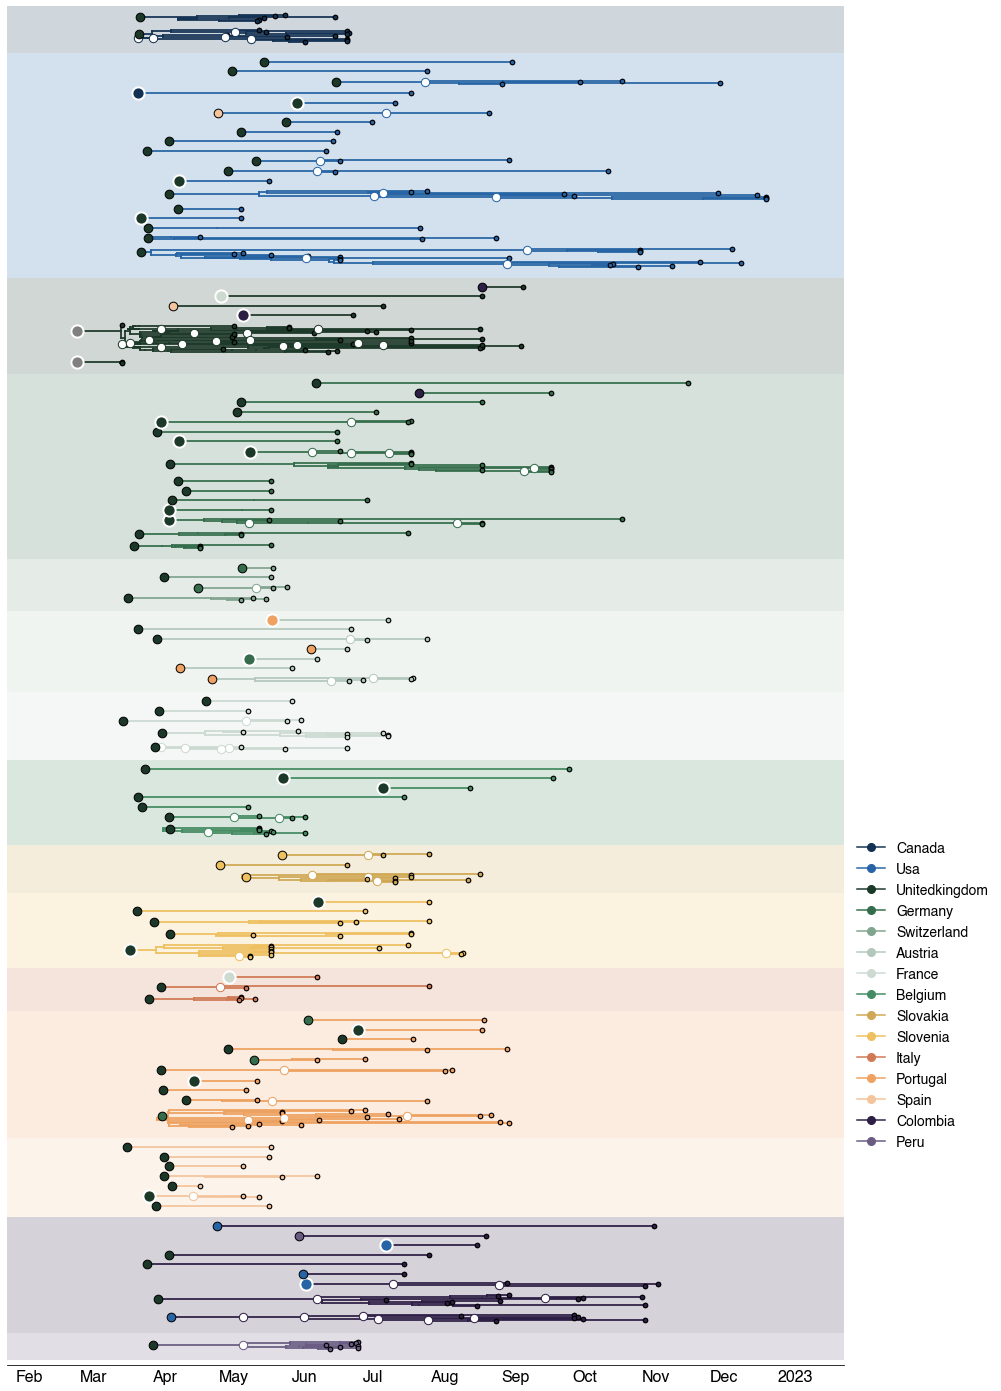

In [810]:
plot_exploded_tree_no_cases(subtype_trees2, exploded_tree_output_file_name2,15,25)  # dotted lines, no case counts


In [795]:
def foo_plot_exploded_tree(subtype_trees2, filename, width, height):
    
    raw_cases = pd.read_csv("../case-rt-analysis/data/monkeypox-cases-counts.tsv", sep="\t")
    raw_cases.location[raw_cases["location"] == "United States"] = "USA"
    raw_cases.location[raw_cases["location"] == "United Kingdom"] = "UnitedKingdom"
    raw_cases.date = raw_cases.date.astype('datetime64[ns]')
    weekly_data = raw_cases.groupby("location").resample('W-Wed', label='right', closed = 'right', on='date').sum().reset_index().sort_values(by=["location","date"])    
    weekly_data["d_date"] = weekly_data['date'].astype("str").apply(lambda x:bt.decimalDate(x) )

    
    heights={division:[] for division in division_order}

    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')
    #ax2 = ax1.twinx()

    traitName='country'
    tipSize=20
    mpl.rcParams['font.size']=16
    cumulative_y=0
    cutoff = 2022.1
    origin_size=100
    cum_bar = 0


    


    for i in reversed(sorted(subtype_trees2.keys(), key=lambda x:key_order[x])):
        starting_y = cumulative_y
        cumulative_y+=10
        for subtree in subtype_trees[i]:
            #print(tr) ## iterate over trait values
            origin = subtree[0]
            loc_tree = subtree[1]
            min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
            



            # count number of total leaves
            number_tips = 0
            for k in loc_tree.Objects:
                if k.branchType == "leaf":
                    number_tips += 1

            """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
            for each node. Do this for all except the horizontal line connecting the origin and the subtee"""
            for k in loc_tree.Objects:

                xp= k.parent.absoluteTime
                x = k.absoluteTime
                y = k.y + cumulative_y
                c = colors[k.traits[traitName]]
                s = tipSize
                a = k.traits["country.prob"]

                if k.branchType == "leaf":
                    ax1.scatter(x,y,s=tipSize,facecolor=c, alpha=a,edgecolor="black",zorder=100) ## plot tip circle
                    ax1.scatter(x,y,s=tipSize,facecolor="black", alpha=a,edgecolor="black",zorder=99)

                elif k.branchType == "node": 
                    # this plots the vertical lines connecting children and parents on tree
                    ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,alpha=a,ls='-',zorder=9)            
                    
                ax1.plot([xp, x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)   # this connects horizontal tree lines
                
                        
                        
                        
            """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
            that line be dotted or solid depending on how far back the origin is and how far back the node is"""
            # first, plot the origin circle
            oriC = colors[origin]

            oriX=loc_tree.root.parent.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
            ax1.scatter(oriX,oriY,s=origin_size,facecolor=oriC,edgecolor='k',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
            
            cumulative_y+=loc_tree.ySpan+8 
        oriC = colors[i]
        ending_y = cumulative_y
        ax1.axhspan(ending_y, starting_y, facecolor=oriC, alpha = 0.15)
        heights[i].append((starting_y, ending_y))

    #overlay country cases    
    for i in reversed(sorted(subtype_trees.keys(), key=lambda x:key_order[x])):
        start = heights[i][0][0]
        end = heights[i][0][1]
        x = weekly_data.loc[weekly_data['location'] == i, "d_date"]
        cases = weekly_data.loc[weekly_data['location'] == i, "cases"]
        
           
        test = ((cases- (min(cases)))/(max(cases)-min(cases)))
        y1 = (((cases- (min(cases)))/(max(cases)-min(cases))) *(end- start))
        testprop= ((end-start)/cumulative_y)

        ax1.bar(x, (y1), color=colors[i], width = 0.01,  alpha = 0.3, bottom = start)
            #ax1.xaxis_date()
    #add in a legend
    han_list = []
    for key in division_order:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[1, 0.15], loc=3, prop={'size': 14}, facecolor='w')
    #lgd = ax.legend(handles = han_list, markerfirst = True, frameon=True, edgecolor="white", bbox_to_anchor=[0.9, 0.15], loc=3, prop={'size': 16}, title=legend_title, title_fontsize=16)
    xDates=['%04d-%02d-01'%(y,m) for y in range(2022,2024) for m in range(1,13)]


    every=1
#     [ax1.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
    ax1.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

    ax1.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
    ax1.tick_params(axis='x',labelsize=16,size=0)  

    #ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(2022.1,2023.1)

    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99720/1497114862.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_cases.location[raw_cases["location"] == "United States"] = "USA"
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_99720/1497114862.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_cases.location[raw_cases["location"] == "United Kingdom"] = "UnitedKingdom"


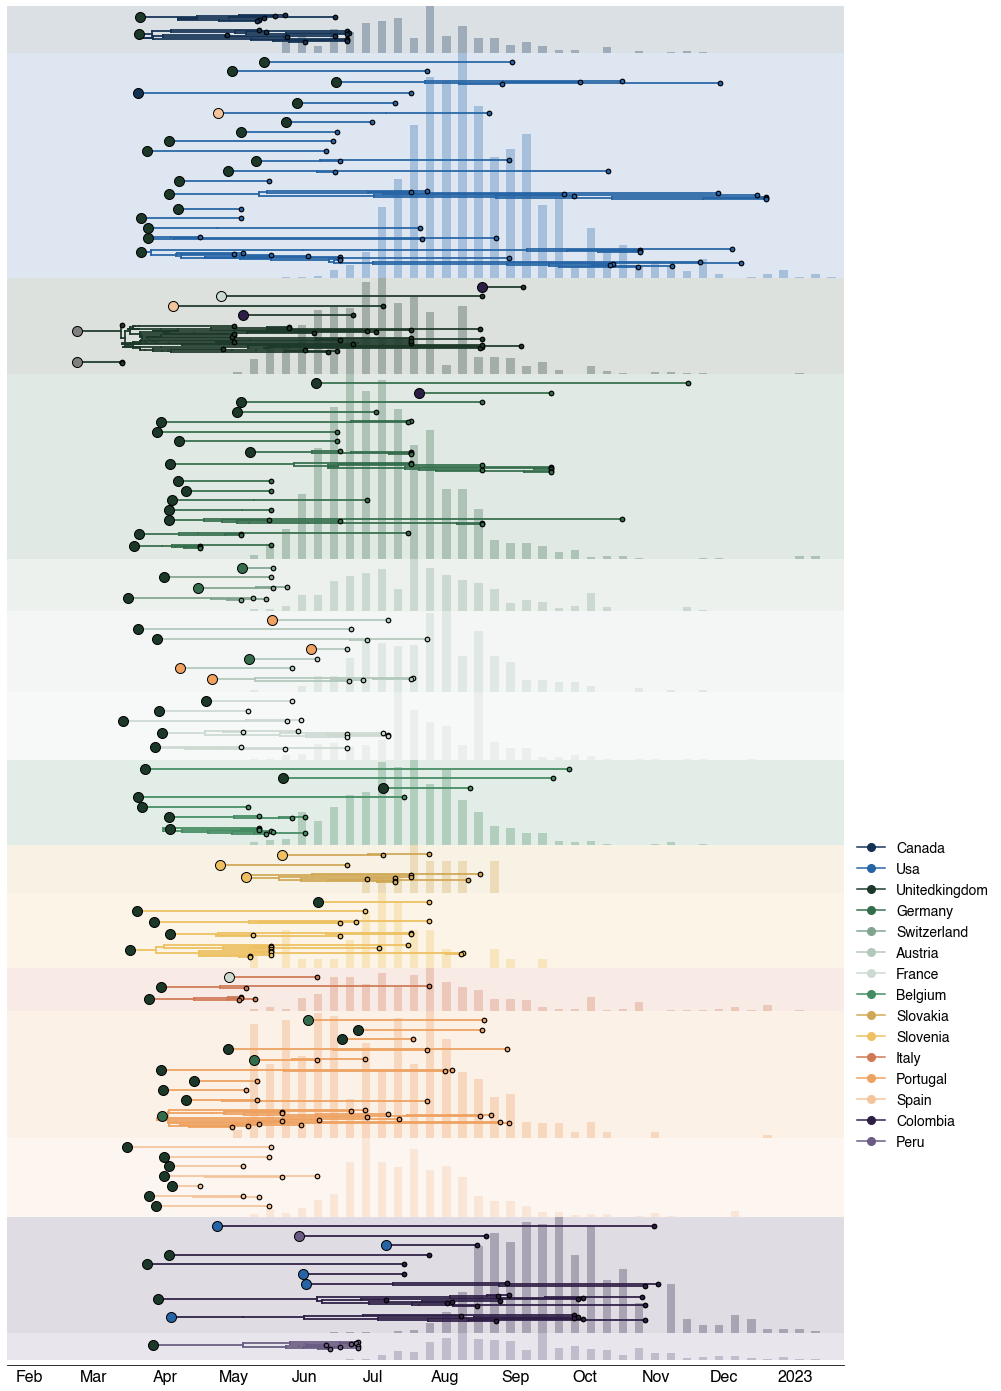

In [796]:
exploded_tree_output_file_name3 = "../figures/country_dta_exploded_tree_with_cases.png"
foo_plot_exploded_tree(subtype_trees2, exploded_tree_output_file_name3,15,25)  # dotted lines, no case counts


In [ ]:
if w.traits['posterior']>=0.5:
                ax.scatter(x,y,s=70,facecolor='w',edgecolor=c,zorder=100)
                if len(w.leaves)>=5 and w.parent.index!='Root':
                    vas=['bottom','top']
                    va=vas[w.parent.children.index(w)-1]
                    ax.text(x-2/365.0,y+((w.parent.children.index(w)-1)*0.2),'%.2f'%(w.traits['posterior']),
                            va=va,ha='right',size=16,path_effects=effects,zorder=101)


<generator object <genexpr> at 0x7ff098ec3120>
<generator object <genexpr> at 0x7ff098ec3120>
[2022.072535   2022.23553195]


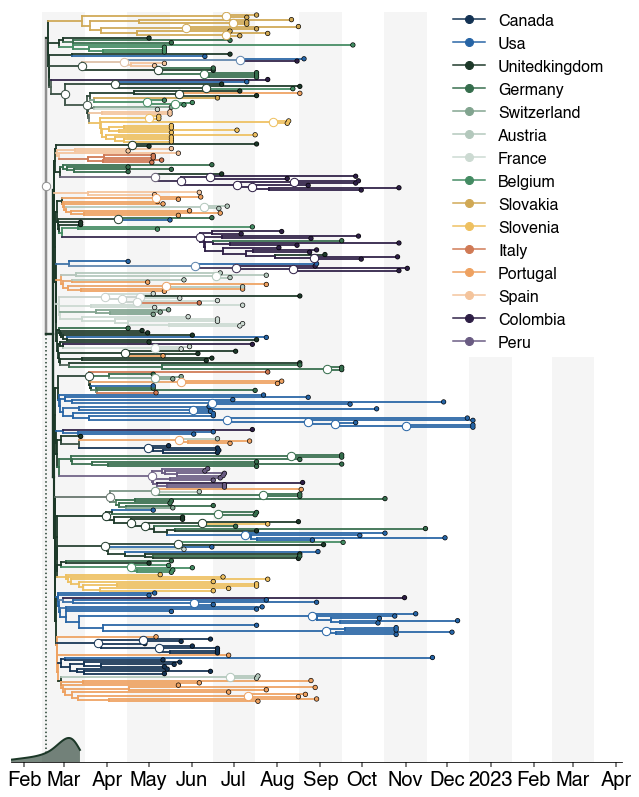

In [794]:
## adding in node cirles to indicate posterior support
root_path = "/Users/mparedes/Desktop/mpox_rhino/300_dta_country_masked.log"
burnin=10000000
with open(root_path) as f:
    f = f.readlines()
for line in f:
    if not line.startswith("#"):
       
        l=line.strip('\n').split('\t')
        if l[0]=='state':
            header=l
            param_idx={x:i for i,x in enumerate(header)}
            params=header[1:]
            rootHeights={x:[] for x in params}
        elif float(l[0])>=burnin:
            for param in params:
                rootHeights[param].append(float(l[param_idx[param]]))

print (np.mean(x) for x in rootHeights.values())
print (np.median(x) for x in rootHeights.values())

print(az.hdi(np.array(rootHeights['age(root)']), 0.95))

fig,ax = plt.subplots(figsize=(10,12),facecolor='w')


traitName = "country"
branchWidth=1.75 ## default branch width
tipSize = 15

#effects=[path_effects.Stroke(linewidth=2, foreground='w'),path_effects.Stroke(linewidth=0.5, foreground='k')]
offsetTree=25
# k objects are tips, nodes, branches
for k in tree.Objects: ## iterate over objects in tree
    x=k.absoluteTime ## or use absolute time instead
    y=k.y + offsetTree
    
    xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        base_color=colors[metadata[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color,base_color], N=256)
        c = color_ramp(node_probs[k])
        s=tipSize
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
    
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        yl=k.children[0].y+offsetTree
        yr=k.children[-1].y+offsetTree
        number_children = len(k.leaves)
        node_branchwidth = branchWidth + number_children*0.0025
        base_color=colors[node_types[k]["division"]]
        color_ramp = clr.LinearSegmentedColormap.from_list('custom ', [uncertainty_color, base_color], N=256)
        c = color_ramp(node_probs[k])
        ax.plot([x,x],[k.children[-1].y+offsetTree,k.children[0].y+offsetTree],lw=node_branchwidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]
        
    

        if k.traits['posterior']>=0.5:
            ax.scatter(x,y,s=70,facecolor='w',edgecolor=c,zorder=100)
#             if len(k.leaves)>=5 and k.parent.index!='Root':
#                 vas=['bottom','top']
#                 va=vas[k.parent.children.index(k)-1]
#                 ax.text(x-2/365.0,y+((k.parent.children.index(k)-1)*0.2),'%.2f'%(k.traits['posterior']),
#                         va=va,ha='right',size=16,zorder=101)
# #                     ax.text(x-2/365.0,y+((k.parent.children.index(w)-1)*0.2),'%.2f'%(k.traits['posterior']),
# #                             va=va,ha='right',size=16,zorder=101)


        if k.parent==tree.root:
#                 location_states=k.traits['%s.states.set'%(traitName)]
#                 location_probs=k.traits['%s.states.set.prob'%(traitName)]
            location_states=k.traits['%s.set'%(traitName)]
            location_probs=k.traits['%s.set.prob'%(traitName)]
            join_probs={a:b for a,b in zip(location_states,location_probs)}
            sort_locations=sorted(join_probs.keys(),key=lambda a:join_probs[a])
            #print [(a,'%.2f'%join_probs[a]) for a in sort_locations]
            width=0.05
            heightRange=yr-yl
            start=yl
            for loc in sort_locations:
                height=heightRange*join_probs[loc]
                #print loc,'%.2f'%(join_probs[loc])
                #country=location_to_country[loc]
                #fc=colours[country](normalized_coords[loc])
                base_color=colors[node_types[k]["division"]]


               
    ax.plot([xp,x],[y,y],lw=node_branchwidth,color=c,ls='-',zorder=9)
        #ax.plot([x,xp],[y,y],color=c,lw=branchWidth,zorder=98)
        #ax.plot([x,x],[yl,yr],color=c,lw=branchWidth,zorder=98)


for intro in rootHeights.keys():
    if intro=='age(root)':

        hpdLo,hpdHi=az.hdi(np.array(rootHeights['age(root)']), 0.95)

        x_grid=np.linspace(hpdLo,hpdHi,100)
        kde=gaussian_kde(rootHeights['age(root)'])
        y_grid=kde.evaluate(x_grid)

        root_y=[(y*0.8)-1 for y in y_grid]


        c='#1C3828'
            #intro='reservoir'



        topX,topY=tree.Objects[0].absoluteTime,tree.Objects[0].children[0].y+offsetTree

        bottomX=topX
        bottomY=(kde.evaluate(bottomX)*0.8)-1

        ax.plot([bottomX,topX],[bottomY,topY],ls=':',color=c)

        ax.fill_between(x_grid,root_y,y2=-1,facecolor= "#1C3828",edgecolor='none',alpha=0.6)
        ax.plot(x_grid,root_y,lw=2,color=c,ls='-')
    
    # add in a legend
    han_list = []

    # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
for key in division_order:
    marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
    han_list.append(marker)

xDates=['%04d-%02d-01'%(y,m) for y in range(2022,2024) for m in range(1,13)]

every=1
[ax.axvspan(bt.decimalDate(xDates[x]),bt.decimalDate(xDates[x])+1/float(12),facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]
ax.set_xticks([bt.decimalDate(x)+1/24.0 for x in xDates if (int(x.split('-')[1])-1)%every==0])

ax.set_xticklabels([convertDate(x,'%Y-%m-%d','%Y') if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])
ax.tick_params(axis='x',labelsize=16,size=0)    
    
# set axis limits, remove border lines         
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.set_ylim(-1,(len(tree.Objects)+1)/2.0+offsetTree+1)
ax.set_xlim(2022.1,2023.3)
ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='x',labelsize=20,size=5, width=2,color='grey')
   # set date labels every 4
ax.set_yticklabels([])

# in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
# bbox arguments are: x, y, with 0 being furthest left and bottom
ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[0.70, 0.53], loc=3,prop={'size': 16}, facecolor='w')

fig.tight_layout()
plt.gcf().subplots_adjust(right=0.88)
#plt.savefig('../figures/mcc_dta_country_300.png',dpi=300,bbox_inches='tight')

plt.show()